In [1]:
# !python.exe -m pip install --upgrade pip
# !pip install imparaai-checkers

In [2]:
# !pip install -U scikit-learn
# !pip install memory-profiler

In [3]:
#import necessary libraries
from checkers.game import Game
import copy
import random
from sklearn.ensemble import RandomForestRegressor
import time
import numpy as np  # Import NumPy
from memory_profiler import memory_usage

In [4]:
class Heuristics:
    #get player piece count that are on the board and are not captured
    @staticmethod
    def get_player_pieces(game, player):
        player_pieces = []
        for piece in game.board.pieces:
            if piece.player == player and not piece.captured:
                player_pieces.append(piece)
        return player_pieces
    
    #get opponent piece count that are on the board and are not captured
    @staticmethod
    def get_opponent_pieces(game, player):
        opponent_pieces = []
        for piece in game.board.pieces:
            if piece.player != player and not piece.captured:
                opponent_pieces.append(piece)
        return opponent_pieces
    
    #heuristics list starts here
    #increase the number of pieces of the player as much as possible, maximize the difference between the player and opponent
    @staticmethod
    def simple_piece_count(game, player):
        player_pieces = Heuristics.get_player_pieces(game, player)
        opponent_pieces = Heuristics.get_opponent_pieces(game, player)
        
        return len(player_pieces) - len(opponent_pieces)
    #heuristics list ends here    

In [5]:
class MinimaxAgent(Heuristics):
    def __init__(self, player):
        self.player = player
        self.regressor = None
    
    def handle_empty_data(self, game, heuristic, observations):
        valid_moves = game.get_possible_moves()
        # handling empty data here
        if not valid_moves:
            return None, False
        return random.choice(valid_moves), True

    def get_best_move(self, game, heuristic, observations, data, stage, L, l):
        # getingt a list of valid moves
        valid_moves = game.get_possible_moves()  
        
        # for RF
        if stage == "RF":
            if self.regressor:
                _, best_move = self.minimax(game, L, True, float('-inf'), float('inf'), heuristic, l, observations)
                if best_move in valid_moves:
                    return best_move, False
                else:
                    #if the best move isn't a valid move choose randomly from valid moves
                    return random.choice(valid_moves), True
        # for rest
        _, best_move = self.minimax(game, L, True, float('-inf'), float('inf'), heuristic, l, observations, stage)
        
        # Ensure the best move is a valid move
        if best_move in valid_moves:
            return best_move, False
        if stage == "RF" or stage == "Hl":
            # If all else fails, handle empty data
            move, flag = self.handle_empty_data(game, heuristic, observations)
            return move, flag



    def minimax(self, game, depth, maximizing_player, alpha, beta, heuristic, l, observations, stage):
        #selection of algorithm (stage) for position evaluation when either the game is over or at the leaf nodes
        if depth == 0 or game.is_over():
            if stage == "H0" or stage == "alpha-beta":
                return self.evaluate_H0(game, heuristic), None
            elif stage == "Hl":
                return self.evaluate_Hl(game, heuristic, l), None
            elif stage == "RF":
                if self.regressor:
                    predicted_HL = self.regressor.predict([list(observations.values())])
                    return predicted_HL[0], None
                else:
                    # If the regressor is not trained, fall back to H0
                    return self.evaluate_H0(game, heuristic), None
            
        if maximizing_player:
            # Initialize the maximum evaluation.
            max_eval = float('-inf')
            # Initialize the best move.
            best_move = None
            
            # Loop through possible moves in the game.
            for move in game.get_possible_moves():
                # Create a copy of the game for simulation.
                next_game = copy.deepcopy(game)
                # Apply the current move to the copy of the game.
                next_game.move(move)

                if stage == "H0":
                    eval = self.evaluate_H0(next_game, heuristic)
                elif stage == "Hl" or stage == "RF" or stage == "alpha-beta":
                    eval, _ = self.minimax(next_game, depth - 1, False, alpha, beta, heuristic, l, observations, stage)
                
    
                # If the evaluation is better than the current maximum: update the maximum evaluationand best move
                if eval > max_eval:
                    max_eval = eval
                    best_move = move

                # Update the alpha value.
                alpha = max(alpha, max_eval)
                # Prune the search if the beta value is less than or equal to alpha.
                if beta <= alpha:
                    break

            return max_eval, best_move
        else:
            # Initialization of the minimizing player
            min_eval = float('inf')
            best_move = None

            # Loop through possible moves in the game.    
            for move in game.get_possible_moves():
                # Create a copy of the game for simulation.
                next_game = copy.deepcopy(game)
                next_game.move(move)

                if stage == "H0":
                    eval = self.evaluate_H0(next_game, heuristic)
                elif stage == "Hl" or stage == "RF" or stage == "alpha-beta":
                    eval, _ = self.minimax(next_game, depth - 1, True, alpha, beta, heuristic, l, observations, stage)
                
                # If the evaluation is worse than the current minimum: update the minimum evaluation and best move
                if eval < min_eval:
                    min_eval = eval
                    best_move = move    

                # Update the alpha value.
                beta = min(beta, min_eval)
                # Prune the search if the beta value is less than or equal to alpha.
                if beta <= alpha:
                    break

            return min_eval, best_move
        
    @staticmethod
    def preprocess_data(data):
        X = [list(observation.values()) for observation, hl_value in data]
        y = [hl_value for observation, hl_value in data]
        return X, y

    def train_regressor(self, data):
        X, y = MinimaxAgent.preprocess_data(data)

        # Filter out samples with non-finite y values and corresponding X values
        finite_indices = [i for i, value in enumerate(y) if np.isfinite(value)]
        if len(finite_indices) != len(y):
            print(f"Removing {len(y) - len(finite_indices)} samples with non-finite y values.")

        X = [X[i] for i in finite_indices]
        y = [y[i] for i in finite_indices]

        print("Number of samples in X after filtering:", len(X))
        print("Number of samples in y after filtering:", len(y))

        # Ensure that X and y have the same number of samples
        if len(X) != len(y):
            raise ValueError("Number of samples in X and y do not match")

        regressor = RandomForestRegressor()
        if len(X) > 0:
            regressor.fit(X, y)
        self.regressor = regressor
    
    
    # Add a method to calculate H0 evaluation for a given game state
    def evaluate_H0(self, game, heuristic):
        if heuristic == "piece_count":
            return Heuristics.simple_piece_count(game, self.player)
        
        
    def evaluate_Hl(self, game, heuristic, l):
        if l == 0:
            return self.evaluate_H0(game, heuristic)

        def depth_l_evaluation(game, current_depth):
            if current_depth == l:
                return self.evaluate_H0(game, heuristic)

            maximizing_player = (current_depth % 2 == 0)

            if maximizing_player:
                max_eval = float('-inf')
                for move in game.get_possible_moves():
                    next_game = copy.deepcopy(game)
                    if next_game.move(move):
                        eval = depth_l_evaluation(next_game, current_depth + 1)
                        max_eval = max(max_eval, eval)
                return max_eval
            else:
                min_eval = float('inf')
                for move in game.get_possible_moves():
                    next_game = copy.deepcopy(game)
                    if next_game.move(move):
                        eval = depth_l_evaluation(next_game, current_depth + 1)
                        min_eval = min(min_eval, eval)
                return min_eval

        # Initialize the evaluation to be computed at level l.
        return depth_l_evaluation(game, current_depth=0)


In [6]:
def play_game(agent, game, heuristic, data, stage, L, l):
    current_player = game.whose_turn()
    game.consecutive_noncapture_move_limit = 20
    opponent_moves_count = 0
    agent_moves_count = 0
    observations = {}
    
    while not game.is_over():
        if current_player == agent.player:
            if stage == "RF":
                observations = {
                    'num_pieces': len(agent.get_player_pieces(game, agent.player))
                }
                
            best_move, random_checker = agent.get_best_move(game, heuristic, observations, data, stage, L, l)
            # Check if the best_move is valid
            valid_moves = game.get_possible_moves()
            
            if best_move in valid_moves:
                game.move(best_move)  # Apply the move
                print(f"Agent's move: {best_move}")
                if stage == "RF":
                    # Collect high-level value for this move (hl_value)
                    hl_value = agent.evaluate_Hl(game, heuristic, 2)

                    # Append observations and hl_value as a tuple to the data list
                    data.append((observations, hl_value))
                                    
        else:
            #the opponent plays randomly for baseline comparison
            opponent_moves = game.get_possible_moves()
            opponent_move = random.choice(opponent_moves)
            game.move(opponent_move)
            opponent_moves_count += 1
            print(f"Opponent's move: {opponent_move}")
            
        # Switch the current player for the next turn
        if not game.move_limit_reached():
            current_player = game.whose_turn()
        else:
            break
    
    winner = game.get_winner()

    if winner == 1:
        return 1
    elif winner == 2:
        return -1
    else:
        return 0
    
def wrapper(agent, game, heuristic, data, stage, L, l):
    global result
    result = play_game(agent, game, heuristic, data, stage, L, l)

piece_count_wins_for_alpha_beta = []
piece_count_wins_for_h0 = []
piece_count_wins_for_hl = []
piece_count_wins_for_rf = []

piece_count_losses_for_alpha_beta = []
piece_count_losses_for_h0 = []
piece_count_losses_for_hl = []
piece_count_losses_for_rf = []

piece_count_draws_for_alpha_beta = []
piece_count_draws_for_h0 = []
piece_count_draws_for_hl = []
piece_count_draws_for_rf = []

piece_count_durations_for_alpha_beta = []
piece_count_durations_for_h0 = []
piece_count_durations_for_hl = []
piece_count_durations_for_rf = []

piece_count_mem_for_alpha_beta = []
piece_count_mem_for_h0 = []
piece_count_mem_for_hl = []
piece_count_mem_for_rf = []

data = []
stages = ["alpha-beta" ,"H0", "Hl", "RF"]
# stages = ["Hl"]
heuristic = 'piece_count'
results_hl_dict = {}
durations_hl_dict = {}
mem_usages_hl_dict = {}

L = 4
l = 3

for stage in stages:
    if stage == "Hl":
        for m in range(1, l+1):
            results_hl = []
            durations_hl = []
            mem_usages_hl = []
            for i in range(10):
                print(f"Comparing {heuristic} for maximizing agents for iteration-{i} and {stage} evaluation and {m}")
                start_time = time.time()
                game = Game()
                agent = MinimaxAgent(1)
                result = None
                mem_usage = None
                mem_usage = memory_usage((wrapper, (agent, game, heuristic, data, stage, L, l)), interval=0.01, max_usage=True)
                results_hl.append(result)
                durations_hl.append(time.time() - start_time)
                mem_usages_hl.append(mem_usage)
            results_hl_dict[m] = results_hl
            durations_hl_dict[m] = durations_hl
            mem_usages_hl_dict[m] = mem_usages_hl
        # print(results_hl_dict)
        # print("!!!!!!")
        # print(durations_hl_dict)
        # print("!!!!!!")
        # print(mem_usages_hl_dict)
    else:
        for i in range(10):
            print(f"Comparing {heuristic} for maximizing agents for iteration-{i} and {stage} evaluation")
            start_time = time.time()
            game = Game()
            agent = MinimaxAgent(1)
            result = None
            mem_usage = None
            mem_usage = memory_usage((wrapper, (agent, game, heuristic, data, stage, L, l)), interval=0.01, max_usage=True)
            # result = play_game(agent, game, heuristic, data, stage, L, l)

            if stage == "alpha-beta":
                piece_count_durations_for_alpha_beta.append(time.time() - start_time)
                piece_count_mem_for_alpha_beta.append(mem_usage)
                if result == 1:
                    piece_count_wins_for_alpha_beta.append(1)
                    piece_count_losses_for_alpha_beta.append(0)
                    piece_count_draws_for_alpha_beta.append(0)
                elif result == -1:
                    piece_count_wins_for_alpha_beta.append(0)
                    piece_count_losses_for_alpha_beta.append(1)
                    piece_count_draws_for_alpha_beta.append(0)
                else:
                    piece_count_wins_for_alpha_beta.append(0)
                    piece_count_losses_for_alpha_beta.append(0)
                    piece_count_draws_for_alpha_beta.append(1)

            elif stage == "H0":
                piece_count_durations_for_h0.append(time.time() - start_time)
                piece_count_mem_for_h0.append(mem_usage)

                if result == 1:
                    piece_count_wins_for_h0.append(1)
                    piece_count_losses_for_h0.append(0)
                    piece_count_draws_for_h0.append(0)
                elif result == -1:
                    piece_count_wins_for_h0.append(0)
                    piece_count_losses_for_h0.append(1)
                    piece_count_draws_for_h0.append(0)
                else:
                    piece_count_wins_for_h0.append(0)
                    piece_count_losses_for_h0.append(0)
                    piece_count_draws_for_h0.append(1)
            elif stage == "RF":
                piece_count_durations_for_rf.append(time.time() - start_time)
                piece_count_mem_for_rf.append(mem_usage)

                if result == 1:
                    piece_count_wins_for_rf.append(1)
                    piece_count_losses_for_rf.append(0)
                    piece_count_draws_for_rf.append(0)
                elif result == -1:
                    piece_count_wins_for_rf.append(0)
                    piece_count_losses_for_rf.append(1)
                    piece_count_draws_for_rf.append(0)
                else:
                    piece_count_wins_for_rf.append(0)
                    piece_count_losses_for_rf.append(0)
                    piece_count_draws_for_rf.append(1)
                
                # Train the regressor using the collected data
                if stage == "RF":
                    agent.train_regressor(data)


print("Results for alpha-beta: ")
print(f"Wins: {piece_count_wins_for_alpha_beta}")
print(f"Losses: {piece_count_losses_for_alpha_beta}")
print(f"Draws: {piece_count_draws_for_alpha_beta}")
print(f"Game durations: {piece_count_durations_for_alpha_beta}")
print(f"Maximum memory usage: {piece_count_mem_for_alpha_beta}")

print("Results for H0: ")
print(f"Wins: {piece_count_wins_for_h0}")
print(f"Losses: {piece_count_losses_for_h0}")
print(f"Draws: {piece_count_draws_for_h0}")
print(f"Game durations: {piece_count_durations_for_h0}")
print(f"Maximum memory usage: {piece_count_mem_for_h0}")

print("Results for Hl: ")
print(f"Game outcomes: {results_hl_dict}")
print(f"Game durations: {durations_hl_dict}")
print(f"Maximum memory usages: {mem_usages_hl_dict}")

print("Results for Random Forest: ")
print(f"Wins: {piece_count_wins_for_rf}")
print(f"Losses: {piece_count_losses_for_rf}")
print(f"Draws: {piece_count_draws_for_rf}")
print(f"Game durations: {piece_count_durations_for_rf}")
print(f"Maximum memory usage: {piece_count_mem_for_rf}")

Comparing piece_count for maximizing agents for iteration-0 and alpha-beta evaluation
Agent's move: [9, 13]
Opponent's move: [22, 17]
Agent's move: [13, 22]
Opponent's move: [25, 18]
Agent's move: [5, 9]
Opponent's move: [29, 25]
Agent's move: [1, 5]
Opponent's move: [26, 22]
Agent's move: [9, 13]
Opponent's move: [23, 19]
Agent's move: [11, 15]
Opponent's move: [18, 11]
Agent's move: [7, 16]
Agent's move: [16, 23]
Opponent's move: [27, 18]
Agent's move: [2, 7]
Opponent's move: [18, 14]
Agent's move: [10, 17]
Agent's move: [17, 26]
Opponent's move: [30, 23]
Agent's move: [5, 9]
Opponent's move: [24, 20]
Agent's move: [6, 10]
Opponent's move: [21, 17]
Agent's move: [13, 22]
Agent's move: [22, 29]
Opponent's move: [31, 27]
Agent's move: [7, 11]
Opponent's move: [23, 18]
Agent's move: [10, 15]
Opponent's move: [27, 23]
Agent's move: [15, 22]
Opponent's move: [23, 18]
Agent's move: [3, 7]
Opponent's move: [28, 24]
Agent's move: [7, 10]
Opponent's move: [18, 15]
Agent's move: [10, 19]
Agent

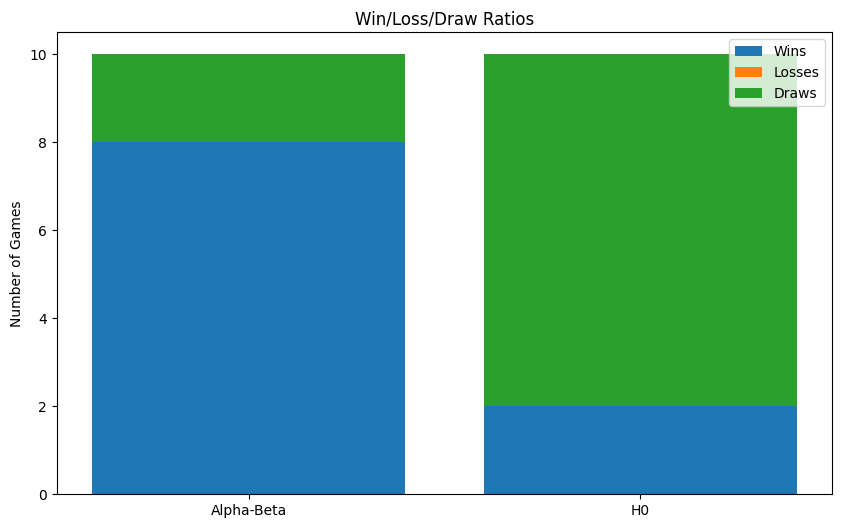

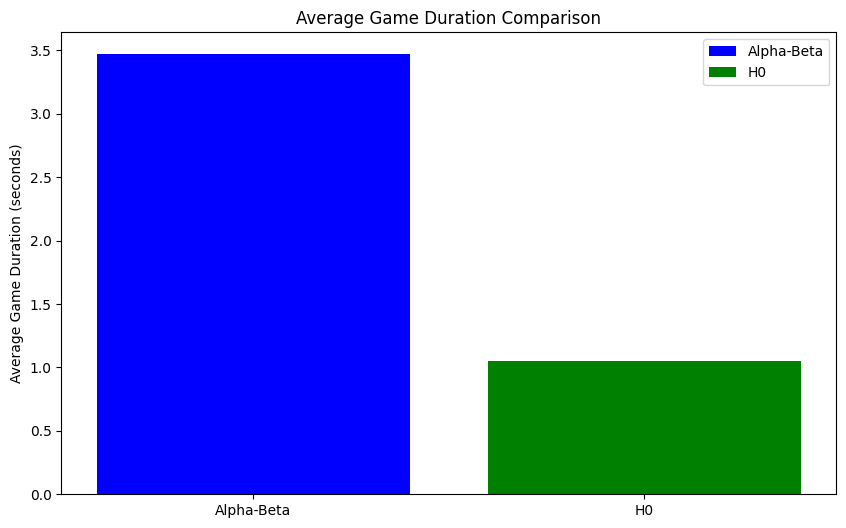

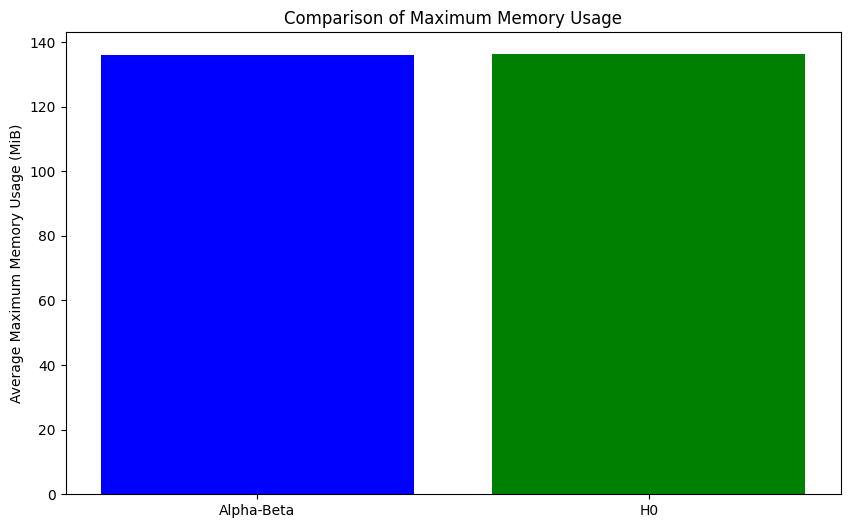

In [7]:
import matplotlib.pyplot as plt

# Stacking Wins, Losses, and Draws
total_games = len(piece_count_wins_for_alpha_beta)
wins = [sum(piece_count_wins_for_alpha_beta), sum(piece_count_wins_for_h0)]
losses = [sum(piece_count_losses_for_alpha_beta), sum(piece_count_losses_for_h0)]
draws = [sum(piece_count_draws_for_alpha_beta), sum(piece_count_draws_for_h0)]

# Win/Loss/Draw Ratios
plt.figure(figsize=(10, 6))
plt.bar(['Alpha-Beta', 'H0'], wins, label='Wins')
plt.bar(['Alpha-Beta', 'H0'], losses, label='Losses', bottom=wins)
plt.bar(['Alpha-Beta', 'H0'], draws, label='Draws', bottom=[wins[j] + losses[j] for j in range(len(wins))])

plt.ylabel('Number of Games')
plt.title('Win/Loss/Draw Ratios')
plt.legend()
plt.show()

# Calculate the average game duration for both strategies
avg_alpha_beta_duration = sum(piece_count_durations_for_alpha_beta) / len(piece_count_durations_for_alpha_beta)
avg_h0_duration = sum(piece_count_durations_for_h0) / len(piece_count_durations_for_h0)

# Creating a bar chart for average game duration comparison
plt.figure(figsize=(10, 6))
plt.bar('Alpha-Beta', avg_alpha_beta_duration, color='blue', label='Alpha-Beta')
plt.bar('H0', avg_h0_duration, color='green', label='H0')
plt.ylabel('Average Game Duration (seconds)')
plt.title('Average Game Duration Comparison')
plt.legend()
plt.show()

# Calculate average memory usage for both strategies
avg_max_alpha_beta_memory = sum(piece_count_mem_for_alpha_beta) / len(piece_count_mem_for_alpha_beta)
avg_max_h0_memory = sum(piece_count_mem_for_h0) / len(piece_count_mem_for_h0)

# Creating a bar chart for maximum memory usage
plt.figure(figsize=(10, 6))
plt.bar('Alpha-Beta', avg_max_alpha_beta_memory, color='blue')
plt.bar('H0', avg_max_h0_memory, color='green')
plt.ylabel('Average Maximum Memory Usage (MiB)')
plt.title('Comparison of Maximum Memory Usage')
plt.show()


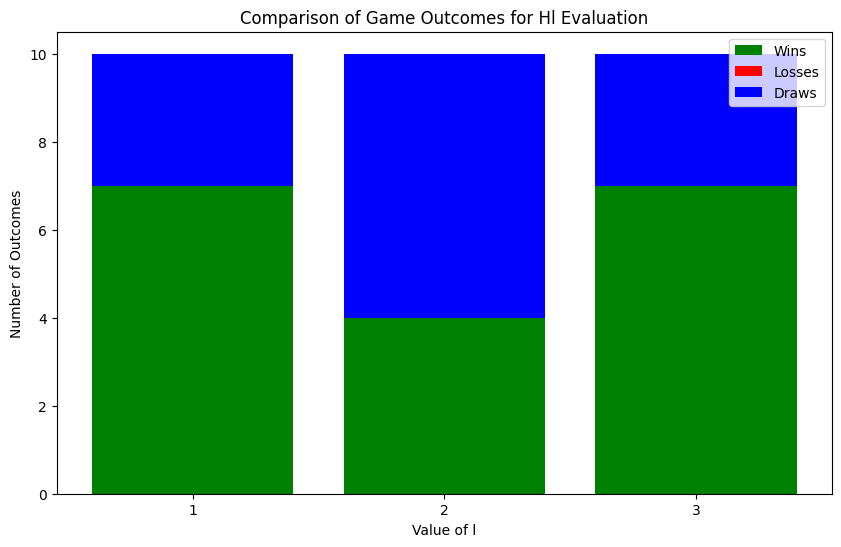

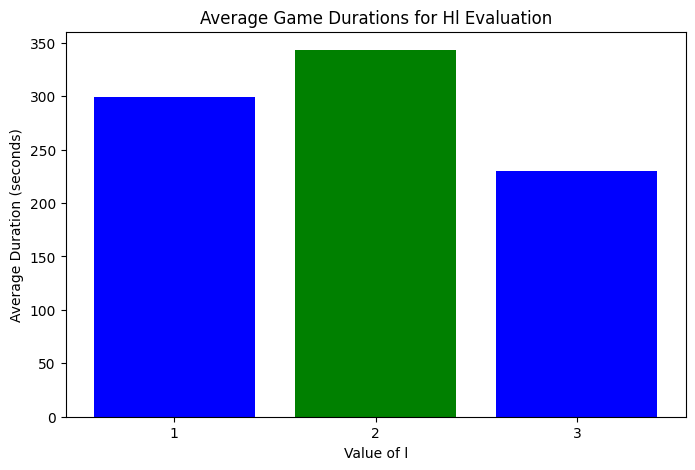

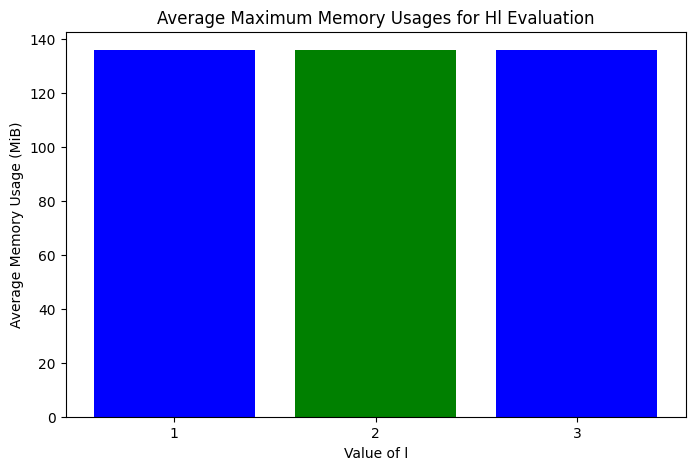

The best l value in Hl evaluation is: 3
Best Wins: [1, 0, 1, 1, 1, 1, 0, 0, 1, 1]
Best Losses: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Best Draws: [0, 1, 0, 0, 0, 0, 1, 1, 0, 0]
Best Game durations: [202.26187944412231, 464.8691680431366, 119.5023148059845, 229.86491775512695, 367.3949239253998, 108.54196786880493, 354.0812306404114, 223.14451718330383, 123.6121575832367, 102.96893072128296]
Best Maximum memory usage: [135.84375, 135.85546875, 135.83984375, 135.85546875, 135.85546875, 135.8515625, 135.85546875, 135.83984375, 135.85546875, 135.85546875]


In [11]:
# Example results data
game_outcomes = results_hl_dict
game_durations = durations_hl_dict
max_memory_usages = mem_usages_hl_dict

# Count wins, losses, and draws for each value of "l"
def count_outcomes(outcomes):
    wins = losses = draws = 0
    for result in outcomes:
        if result == 1:
            wins += 1
        elif result == -1:
            losses += 1
        else:  # Draws are represented as 0
            draws += 1
    return wins, losses, draws

outcomes_count = {l: count_outcomes(results) for l, results in game_outcomes.items()}

# Data for the stacked bar chart
labels = outcomes_count.keys()
wins = [count[0] for count in outcomes_count.values()]
losses = [count[1] for count in outcomes_count.values()]
draws = [count[2] for count in outcomes_count.values()]

# Plotting the stacked bar chart
plt.figure(figsize=(10, 6))

# Plot wins
plt.bar(labels, wins, color='green', label='Wins')

# Stack losses on top of wins
plt.bar(labels, losses, bottom=wins, color='red', label='Losses')

# Stack draws on top of wins+losses
plt.bar(labels, draws, bottom=[wins[i] + losses[i] for i in range(len(wins))], color='blue', label='Draws')

plt.xlabel('Value of l')
plt.ylabel('Number of Outcomes')
plt.title('Comparison of Game Outcomes for Hl Evaluation')
plt.xticks([1, 2, 3])
plt.legend()
plt.show()

# Bar chart for average game durations
avg_durations = {l: sum(durations) / len(durations) for l, durations in game_durations.items()}
plt.figure(figsize=(8, 5))
plt.bar(avg_durations.keys(), avg_durations.values(), color=['blue', 'green'])
plt.title('Average Game Durations for Hl Evaluation')
plt.xlabel('Value of l')
plt.ylabel('Average Duration (seconds)')
plt.xticks([1, 2, 3])
plt.show()

# Bar chart for average maximum memory usages
avg_memory_usages = {l: sum(mem_usages) / len(mem_usages) for l, mem_usages in max_memory_usages.items()}
plt.figure(figsize=(8, 5))
plt.bar(avg_memory_usages.keys(), avg_memory_usages.values(), color=['blue', 'green'])
plt.title('Average Maximum Memory Usages for Hl Evaluation')
plt.xlabel('Value of l')
plt.ylabel('Average Memory Usage (MiB)')
plt.xticks([1, 2, 3])
plt.show()

# For wins, we want the higher number; for losses, we want the lower number; for durations and memory usage, we want the lower number
best_l = max(game_outcomes, key=lambda l: (sum(1 for result in game_outcomes[l] if result == 1),
                                           -sum(1 for result in game_outcomes[l] if result == -1),
                                           -avg_durations[l], 
                                           -avg_memory_usages[l]))

# Now, extract the data for the best "l"
piece_count_wins_for_hl = [1 if outcome == 1 else 0 for outcome in game_outcomes[best_l]]
piece_count_losses_for_hl = [1 if outcome == -1 else 0 for outcome in game_outcomes[best_l]]
piece_count_draws_for_hl = [1 if outcome == 0 else 0 for outcome in game_outcomes[best_l]]
piece_count_durations_for_hl = game_durations[best_l]
piece_count_mem_for_hl = max_memory_usages[best_l]

# Print the best "l" value and the lists
print(f"The best l value in Hl evaluation is: {best_l}")
print("Best Wins:", piece_count_wins_for_hl)
print("Best Losses:", piece_count_losses_for_hl)
print("Best Draws:", piece_count_draws_for_hl)
print("Best Game durations:", piece_count_durations_for_hl)
print("Best Maximum memory usage:", piece_count_mem_for_hl)


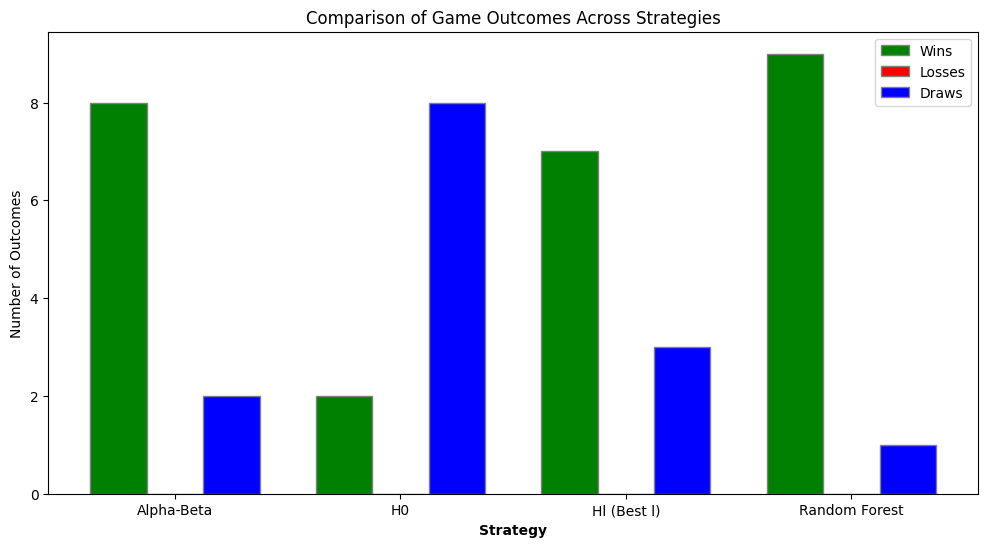

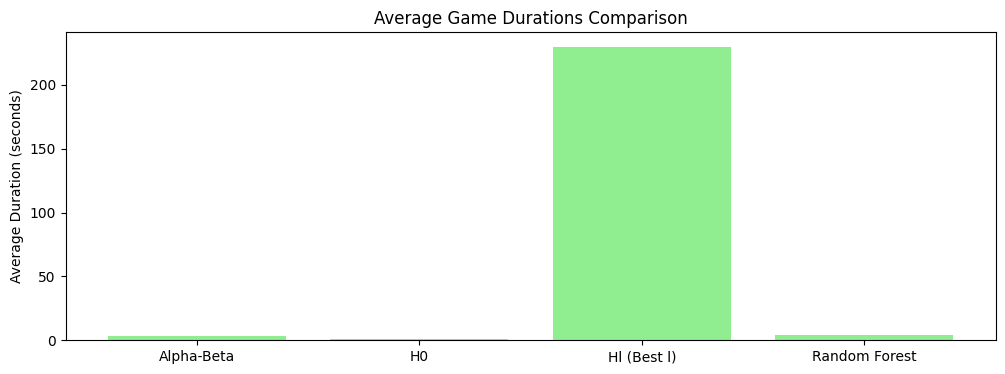

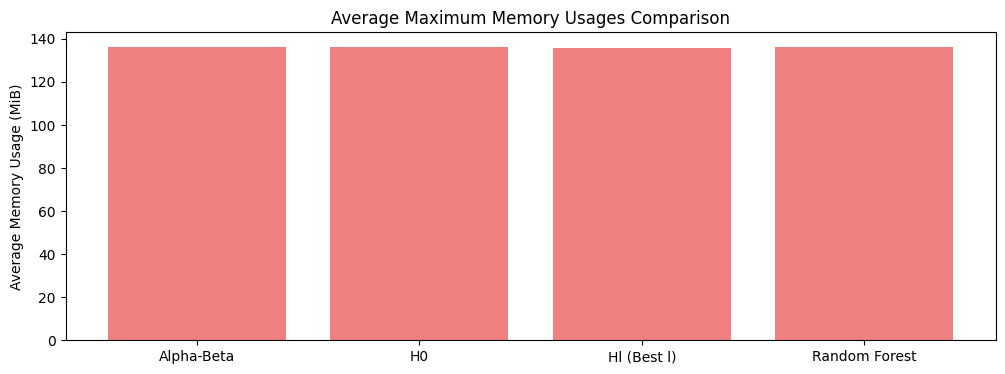

In [9]:
# Function to calculate average
def calculate_average(data):
    return sum(data) / len(data)

# Function to calculate win rate
def calculate_win_rate(wins, losses, draws):
    total_games = len(wins) + len(losses) + len(draws)
    return sum(wins) / total_games

# Calculate win rates, average durations, and average memory usages
win_rates = {
    'Alpha-Beta': calculate_win_rate(piece_count_wins_for_alpha_beta, piece_count_losses_for_alpha_beta, piece_count_draws_for_alpha_beta),
    'H0': calculate_win_rate(piece_count_wins_for_alpha_beta, piece_count_losses_for_h0, piece_count_draws_for_h0),
    'Hl (Best l)': calculate_win_rate(piece_count_wins_for_hl, piece_count_losses_for_hl, piece_count_draws_for_hl),
    'Random Forest': calculate_win_rate(piece_count_wins_for_rf, piece_count_losses_for_rf, piece_count_draws_for_rf)
}

strategies = ['Alpha-Beta', 'H0', 'Hl (Best l)', 'Random Forest']
wins = [sum(piece_count_wins_for_alpha_beta), sum(piece_count_wins_for_h0), sum(piece_count_wins_for_hl), sum(piece_count_wins_for_rf)]
losses = [sum(piece_count_losses_for_alpha_beta), sum(piece_count_losses_for_h0), sum(piece_count_losses_for_hl), sum(piece_count_losses_for_rf)]
draws = [sum(piece_count_draws_for_alpha_beta), sum(piece_count_draws_for_h0), sum(piece_count_draws_for_hl), sum(piece_count_draws_for_rf)]

average_durations = {
    'Alpha-Beta': calculate_average(piece_count_durations_for_alpha_beta),
    'H0': calculate_average(piece_count_durations_for_h0),
    'Hl (Best l)': calculate_average(piece_count_durations_for_hl),
    'Random Forest': calculate_average(piece_count_durations_for_rf)
}

average_memory_usages = {
    'Alpha-Beta': calculate_average(piece_count_mem_for_alpha_beta),
    'H0': calculate_average(piece_count_mem_for_h0),
    'Hl (Best l)': calculate_average(piece_count_mem_for_hl),
    'Random Forest': calculate_average(piece_count_mem_for_rf)
}

# Define the bar width
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(wins))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Make the plot
plt.figure(figsize=(12, 6))

plt.bar(r1, wins, color='g', width=bar_width, edgecolor='grey', label='Wins')
plt.bar(r2, losses, color='r', width=bar_width, edgecolor='grey', label='Losses')
plt.bar(r3, draws, color='b', width=bar_width, edgecolor='grey', label='Draws')

# Add xticks on the middle of the group bars
plt.xlabel('Strategy', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(wins))], strategies)

plt.ylabel('Number of Outcomes')
plt.title('Comparison of Game Outcomes Across Strategies')

# Create legend & Show graphic
plt.legend()
plt.show()


plt.figure(figsize=(12, 4))
plt.bar(average_durations.keys(), average_durations.values(), color='lightgreen')
plt.title('Average Game Durations Comparison')
plt.ylabel('Average Duration (seconds)')
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(average_memory_usages.keys(), average_memory_usages.values(), color='lightcoral')
plt.title('Average Maximum Memory Usages Comparison')
plt.ylabel('Average Memory Usage (MiB)')
plt.show()